# README

This is the most recent version of the GCS code. There are two copies of this notebook, where each one gives ready access to a specific configuration displaying a specific example. 

## How to run
You might need to add a Mosek License if Mosek is being used. For how to store the Mosek license so it can be accessed by the code, simply add the license to "Files" as indicated by the directories in the Mosek license cell. Apart from that, the notebook should run as is. 

There are two main immediately runable examples, the copy example, and the normal. For these to successfully run, constants, terrains and constraints need to match and form a feasible problem. 

There are two copies of this notebook for ready access to both of these examples, where the terrain, constants and constraints are pre-set to display these examples. 

## How to generate, save and read Terrain: 
Do something akin to:
```
T = Terrain([
             [1,[[b,b]],[[0.25,0.25],[0.25,0.25]],1],
            ],
            1.0,1.0,(0,0),(0,3))
            
T.plot()
T.store_terrain_to_file("terrain_dict.txt")
```
There is a cell that does that, scroll down to find it. 

## How to configure
Multiple places in the code there is the text "NOTE:", under which you find code you can comment in and out. Commenting in and out here should allow you to reproduce all the conditions described in our term report.

In [1]:
# python libraries
import numpy as np
from IPython.display import IFrame, display
from matplotlib import pyplot as plt
from matplotlib import rcParams
from pydrake.all import GraphOfConvexSets, GraphOfConvexSetsOptions, HPolyhedron, Point
from pydrake.solvers import SnoptSolver
from pydrake.solvers import MosekSolver
from pydrake.solvers import ClarabelSolver
from pydrake.solvers import SolverOptions
from pydrake.math import ge
from pydrake.solvers import CommonSolverOption

import pickle

import time

from underactuated.exercises.humanoids.footstep_planning_gcs_utils import (
    animate_footstep_plan,
    plot_rectangle,
)
from underactuated.exercises.humanoids.test_footstep_planning_gcs import (
    TestFootstepPlanning,
)

# increase default size matplotlib figures

rcParams["figure.figsize"] = (10, 5)

# import helper functions
from scipy.linalg import block_diag
from collections import deque

In [2]:
class SteppingStone(object):
    def __init__(self, center, width, height, name=None):
        # store arguments
        self.center = center
        self.width = width
        self.height = height
        self.name = name
        self.V = []

        # distance from center to corners
        c2tr = np.array([width, height]) / 2
        c2br = np.array([width, -height]) / 2

        # position of the corners
        self.top_right = center + c2tr
        self.bottom_right = center + c2br
        self.top_left = center - c2br
        self.bottom_left = center - c2tr
        self.corners = [self.top_right, self.bottom_right, self.top_left, self.bottom_left]

        # halfspace representation of the stepping stone
        self.A = np.array([[1, 0], [0, 1], [-1, 0], [0, -1]])
        self.b = np.concatenate([c2tr] * 2) + self.A.dot(center)

    def plot(self, **kwargs):
        return plot_rectangle(self.center, self.width, self.height, **kwargs)

    def min_dist(self, other_stone):
        min_dist = np.inf
        for self_corner in self.corners:
                for other_corner in other_stone.corners:
                    dist = np.linalg.norm(self_corner - other_corner)
                    if dist < min_dist:
                        min_dist = dist
        return min_dist

In [3]:
class Terrain(object):
    def __init__(self, matrix, base_width,base_height,src_coords,dst_coords):
        self.matrix = np.array(matrix,dtype=object)
        self.base_width = base_width
        self.base_height = base_height
        self.stepping_stones = []

        self.create_stones_from_matrix(self.matrix,0, 0, self.base_width, self.base_height, src_coords, dst_coords,0,0)

    def create_stones_from_matrix(self, matrix, ox, oy, base_width, base_height, src_coords,dst_coords, r_idx,c_idx):
        try:
            #rows, cols = matrix.shape
            rows = len(matrix)
            cols = len(matrix[0])
        except:
            print("numpy will turn tuples into arrays if all sub-elements are equal dimension")
            print("instead of [[(0.5,0.5),(0.5,0.5)]] try [[(0.5,0.5),0.5]]")
        for r in range(rows):
            for c in range(cols):
                center_x = ox + c * base_width + base_width / 2
                center_y = oy + (rows - 1 - r) * base_height + base_height / 2
                item = matrix[r][c]#[r,c]
                #print(item)
                #factorx = 1 # TODO: figure out why this line wasn't necesasry before. This should always give "before assignment error", but it hasn't before now
                if isinstance(item, list):
                    submatrix = item#np.array(item, dtype=object)
                    new_base_width = base_width/len(submatrix[0])
                    new_base_height = base_height/len(submatrix)
                    self.create_stones_from_matrix(submatrix,center_x-base_width/2, center_y-base_height/2,new_base_width, new_base_height, (-1,-1),(-1,-1),r,c)
                    continue
                elif isinstance(item, tuple):
                    factorx = item[0]
                    factory = item[1]
                elif isinstance(item, (float, int)):
                    factorx = item
                    factory = item
                else:
                    print(type(item))
                    print(item)
                    assert 0, "how is this possible?"
                if factorx > 0:
                    
                    width = self.base_width * factorx
                    height = self.base_height * factory
                    center = np.array([center_x, center_y])
                    
                    if (r,c)==src_coords:
                        name = "initial"
                    elif (r,c)==dst_coords:
                        name = "goal"
                    else:
                        #name = f"stone_{rows - 1 - r}_{c}"
                        if(r_idx!=0 or c_idx!=0):
                            name = f"stone_{r_idx}.{r}_{c_idx}.{c}"
                        else:
                            name = f"stone_{r}_{c}"
                    
                    self.add_stone(center, width, height, name)

    def add_stone(self, center, width, height, name=None):
        stone = SteppingStone(center, width, height, name=name)
        self.stepping_stones.append(stone)
        return stone

    def plot(self, title=None, **kwargs):
        # make light green the default facecolor
        if not "facecolor" in kwargs:
            std_color = [0, 1, 0, 0.1]

        # plot stepping stones disposition
        labels = ["Stepping stone", None]
        for i, stone in enumerate(self.stepping_stones):
            if stone.name == "goal":
                kwargs["facecolor"] = [0,1,0,1]
            elif stone.name == "initial":
                kwargs["facecolor"] = [0,1,1,1]
            else:
                kwargs["facecolor"] = std_color
            stone.plot(label=labels[min(i, 1)], **kwargs)

        # set title
        plt.title(title)

    def get_stone_by_name(self, name):
        # loop through the stones
        # select the first with the given name
        for stone in self.stepping_stones:
            if stone.name == name:
                return stone
        # raise error if there is no stone with the given name
        raise ValueError(f"No stone in the terrain has name {name}.")

    # stores terrain as a dict {stone1name : [x,y,length, width, height], stone2name : [x,y,length, width, height]}
    # @Warning: What Spot env considers (env:length, env:width, env:height) == (stone.width, stone.height, NaN)
    def store_terrain_to_file(self, filename):
        terrain_dict = {}
        for stone in self.stepping_stones:
            use_name = stone.name
            if stone.name in terrain_dict:
                use_name = use_name + "2"

            #                                        x,               y,   env:length,    env:width, env:height
            terrain_dict[use_name] = {"x" : stone.center[0], 
                                        "y" : stone.center[1], 
                                        "length" : stone.width, 
                                        "width" : stone.height,  
                                        "height" : 0.1}
        
        f = open(filename, "wb")
        pickle.dump(terrain_dict, f)

    
#T = Terrain([
#             [1,0.85, [[(0.25,0.25), 0.5],[0.25,0.25]],0,0,0,0],
#             [[[(0.25,0.9),(0.25,.9)]],0,0,0,0,0,0],
#             [[[0.25,0.25]],0,0,0,0,0,0],
#             [[[(0.25,0.9),(0.25,0.9)]],[[0,0],[0.25,0]],0,0,0,0,0,0],
#             [[[0,0.25],[0,0]],[[(0.85,0.25)],[(1.0,0.25)]],[[(0.85,0.25)],[(1.0,0.25)]],[[(0.85,0.25)],[(1.0,0.25)]],[[(0.85,0.25)],[(1.0,0.25)]],[[(0.85,0.25)],[(1.0,0.25)]],1]
#            ],
#             
#             0.5,0.5, (0,0), (6,4))

In [4]:
from pydrake.solvers import MathematicalProgram, Solve
class ConvexVertex(object):
    #def __init__(self, A1,b1,A2,b2,A3,b3,A4,b4,centre, width)
    def __init__(self, stone1, stone1_idx, stone2, stone2_idx):#, stone3, stone4):
        self.stone1=stone1
        self.stone2=stone2
        self.stone1_idx=stone1_idx #stone "1" refers to LF being foot 1
        self.stone2_idx=stone2_idx #stone "2" refers to RF being foot 2

        A1 = stone1.A
        A2 = stone2.A
        #A3 = stone3.A
        #A4 = stone4.A

        b1 = stone1.b
        b2 = stone2.b
        #b3 = stone3.b
        #b4 = stone4.b

        self.A = block_diag(A1,A2)#,A3,A4)
        self.b = np.concatenate((b1,b2))#,b3,b4))
        self.HPoly = HPolyhedron(self.A,self.b)
        #TODO: centre and width
        #self.centre = centre_idx
        #self.width = width
        self.center = (stone1.center + stone2.center)*(1/num_feet)

    def add_GCS_vertex(self, GCS_type_vertex):
        self.GCS_vertex = GCS_type_vertex

    # check if this and other are close enough
    def near(self, other_vertex, step_span, sprawl_spanx, sprawl_spany):
        # check if at least one stone is the same
        same_stone1 = self.stone1_idx == other_vertex.stone1_idx
        same_stone2 = self.stone2_idx == other_vertex.stone2_idx

        if not same_stone1 and not same_stone2:
            return False

        elif not same_stone1:
            # stone 1 is different, check min dist
            min_dist_step = self.stone1.min_dist(other_vertex.stone1)
            min_dist_sprawl = self.stone2.min_dist(other_vertex.stone1)
            return (min_dist_step < step_span) and (min_dist_sprawl < max(sprawl_spanx, sprawl_spany))

        elif not same_stone2:
            # stone 2 is different, check min dist
            min_dist_step = self.stone2.min_dist(other_vertex.stone2)
            min_dist_sprawl = self.stone1.min_dist(other_vertex.stone2)
            return (min_dist_step < step_span) and (min_dist_sprawl < max(sprawl_spanx, sprawl_spany))

        else:
            # TODO: both stones are the same, need to handle copies
            return False
    
        # Used as replacement of .near() function. Checks if there exists a feasible transition from one 
    # set of foot placements to another
    # in practice, turns out this is actually slower than using Lukas's .near(). But it adds slightly more edges?
    def check_feasibility(self, other_vertex, step, sprawlx, sprawly):
        A1 = self.A
        b1 = self.b
        A2 = other_vertex.A
        b2 = other_vertex.b

        prog = MathematicalProgram()

        u = prog.NewContinuousVariables(4, "u")
        v = prog.NewContinuousVariables(4, "v")
        x = np.hstack((u,v))

        same_stone1 = self.stone1_idx == other_vertex.stone1_idx
        same_stone2 = self.stone2_idx == other_vertex.stone2_idx

        if not same_stone1 and not same_stone2:
            return False
        elif same_stone1 and same_stone2:
            #TODO: handle copies
            return False
        elif same_stone1: #rf moving
            moving_x_idx = 2
            moving_y_idx = 3
            still_x_idx = 0
            still_y_idx = 1
        elif same_stone2: #lf moving
            moving_x_idx = 0
            moving_y_idx = 1
            still_x_idx = 2
            still_y_idx = 3
        else:
            assert(0), "what?"

        #TODO: Going right/left or going up/down mode. Will affect which foot is constrained to be north/south or east/west 
        # of the other. Currently **left to right is assumed** this means left leg above right leg
        # left leg y idx = 1, right leg y idx = 3 
        # up/down left/right
        #delta_left_right = 0.3
        #prog.AddConstraint(v[1]>=v[3]+delta_left_right)
    
        #moving leg
        prog.AddConstraint((u-v)[moving_x_idx] <=  step)
        prog.AddConstraint((u-v)[moving_x_idx] >= -step)
        prog.AddConstraint((u-v)[moving_y_idx] <=  step)
        prog.AddConstraint((u-v)[moving_y_idx] >= -step)
    
        #stance leg
        prog.AddConstraint(u[still_x_idx] == v[still_x_idx])
        prog.AddConstraint(u[still_y_idx] == v[still_y_idx])
    
        #don't step too far away from the other foot
        prog.AddConstraint(u[still_x_idx]-v[moving_x_idx] <=  sprawlx)
        prog.AddConstraint(u[still_x_idx]-v[moving_x_idx] >= -sprawlx)
        prog.AddConstraint(u[still_y_idx]-v[moving_y_idx] <=  sprawly)
        prog.AddConstraint(u[still_y_idx]-v[moving_y_idx] >= -sprawly)
    
        result = Solve(prog)
        if result.is_success() == True:
            return True
        else:
            return False

    # intended to be used to check if you are close enough to the goal vertex 
    # TODO: why does the below use stone 1 in all cases? That's wrong right?
    def near_point(self, gcs_point, thresh=1.0):
        min_dist = np.inf
        for corner in self.stone1.corners:
            dist = np.linalg.norm(corner - gcs_point.x()[0:num_feet])
            if dist < min_dist:
                min_dist = dist
        for corner in self.stone1.corners:
            dist = np.linalg.norm(corner - gcs_point.x()[0:num_feet])
            if dist < min_dist:
                min_dist = dist
        for corner in self.stone1.corners:
            dist = np.linalg.norm(corner - gcs_point.x()[num_feet:])
            if dist < min_dist:
                min_dist = dist
        for corner in self.stone1.corners:
            dist = np.linalg.norm(corner - gcs_point.x()[num_feet:])
            if dist < min_dist:
                min_dist = dist
        return dist < thresh
        

In [5]:
class GCS_footstep_problem_bookkeeping:
    def __init__(self, Vgcs, Egcs, Ggcs, K, existing_edges, existing_vertices, Vtodo, goal_config, goal_vertex_idx):
        self.Vgcs = Vgcs
        self.Egcs = Egcs
        self.Ggcs = Ggcs
        self.K = K
        self.existing_edges = existing_edges
        self.existing_vertices = existing_vertices
        self.Vtodo = Vtodo
        self.goal_config = goal_config
        self.goal_vertex_idx = goal_vertex_idx

In [6]:
def expand_graph(new_edge, reverse_new_edge, new_vertex_indices, u, left_right_enum, book_keeping : GCS_footstep_problem_bookkeeping):

    #(G, Egcs, new_edge, reverse_new_edge, new_vertex_indices, u, left_right_enum, existing_edges, existing_vertices, 
    #Vgcs,Vtodo,K,goal_config, goal_vertex_idx)
    G = book_keeping.Ggcs
    Egcs = book_keeping.Egcs
    existing_edges = book_keeping.existing_edges
    existing_vertices = book_keeping.existing_vertices
    Vgcs = book_keeping.Vgcs
    Vtodo = book_keeping.Vtodo
    K = book_keeping.K
    goal_config = book_keeping.goal_config
    goal_vertex_idx = book_keeping.goal_vertex_idx

    a = new_vertex_indices[0]
    b = new_vertex_indices[1]
    
    if ((new_edge not in existing_edges)):# and ((reverse_new_edge not in existing_edges)):
        v_dummy = ConvexVertex(K[a], a, K[b], b)
        #if u.near(v_dummy, step_span, sprawl_spanx, sprawl_spany):
        feas_bool = u.check_feasibility(v_dummy, step_span, sprawl_spanx, sprawl_spany)
        if feas_bool:
            #print(f"u: {u.center}, v: {v_dummy.center}")
            existing_edges.add(new_edge)

            if new_vertex_indices not in existing_vertices:
                Vgcs.append(G.AddVertex(v_dummy.HPoly, str(v_dummy.stone1_idx)+'_'+str(v_dummy.stone2_idx)))
                v_dummy.add_GCS_vertex(Vgcs[-1])
                existing_vertices[new_vertex_indices] = v_dummy
                Vtodo.append(v_dummy)
                try:
                    G, Egcs = add_edge_and_edge_constraint_to_graph(G, Egcs, u.GCS_vertex, v_dummy.GCS_vertex, left_right_enum, step_span, sprawl_spanx,sprawl_spany)
                except:
                    print("fuck")

                # TODO: instead of below, remove vertices without outgoing edges
                if (v_dummy.near_point(Point(goal_config), step_span)):
                    #existing_edges.add(())... this isn't implemented, that's alright, we won't get 
                    #duplicate edges because this only happens at vertex creation
                    G, Egcs = add_edge_and_edge_constraint_to_graph(G, Egcs, v_dummy.GCS_vertex, Vgcs[goal_vertex_idx], left_right_enum, step_span, sprawl_spanx,sprawl_spany)
            else: 
                #try: 
                    v = existing_vertices[new_vertex_indices]
                    G, Egcs = add_edge_and_edge_constraint_to_graph(G, Egcs, u.GCS_vertex, v.GCS_vertex, left_right_enum, step_span, sprawl_spanx,sprawl_spany)
                #except:
                #    print("fuck v")
    return G, Egcs

def add_edge_and_edge_constraint_to_graph(G, E, u, v, left_or_right_step, step_span, sprawl_spanx,sprawl_spany):

    e = G.AddEdge(u,v)

    if left_or_right_step == left_enum: #left
       moving_x_idx = 0
       moving_y_idx = 1
       still_x_idx = 2
       still_y_idx = 3


    if left_or_right_step == right_enum: #right
        moving_x_idx = 2
        moving_y_idx = 3
        still_x_idx = 0
        still_y_idx = 1

    #TODO: Going right/left or going up/down mode. Will affect which foot is constrained to be north/south or east/west 
    # of the other. Currently **left to right is assumed** this means left leg above right leg
    # left leg y idx = 1, right leg y idx = 3 
    # up/down left/right
    ## NOTE: UNCOMMENT BELOW TO ADD THIS CONSTRAINT
    # Also note, the below will not work with the copy terrain example
    #delta_left_right = 0.3
    #e.AddConstraint(e.xv()[1]>=e.xv()[3]+delta_left_right)

    #moving leg
    e.AddConstraint((e.xu()-e.xv())[moving_x_idx] <=  step_span)
    e.AddConstraint((e.xu()-e.xv())[moving_x_idx] >= -step_span)
    e.AddConstraint((e.xu()-e.xv())[moving_y_idx] <=  step_span)
    e.AddConstraint((e.xu()-e.xv())[moving_y_idx] >= -step_span)

    #stance leg
    e.AddConstraint((e.xu())[still_x_idx] == (e.xv())[still_x_idx])
    e.AddConstraint((e.xu())[still_y_idx] == (e.xv())[still_y_idx])

    #don't step too far away from the other foot
    e.AddConstraint(e.xu()[still_x_idx]-e.xv()[moving_x_idx] <=  sprawl_spanx)
    e.AddConstraint(e.xu()[still_x_idx]-e.xv()[moving_x_idx] >= -sprawl_spanx)
    e.AddConstraint(e.xu()[still_y_idx]-e.xv()[moving_y_idx] <=  sprawl_spany)
    e.AddConstraint(e.xu()[still_y_idx]-e.xv()[moving_y_idx] >= -sprawl_spany)

    # Don't step too close to other foot
    #<Transcription.kRestriction: 2> from https://drake.mit.edu/pydrake/pydrake.geometry.optimization.html

    distance_between_feet = (e.xv()[still_x_idx:still_y_idx+1]-e.xv()[moving_x_idx:moving_y_idx+1])

    dist = np.linalg.norm(distance_between_feet)

    ## NOTE: TO BE ABLE TO UNCOMMENT CODE BELOW AND RUN WITHOUT ERROR, USE NEWER VERSION OF PYDRAKE
    #print(type(dist))
    #transcription_sets = set()
    #transcription_sets.add(GraphOfConvexSets.Transcription(2))
    
    #e.AddConstraint(dist>=balance_req, transcription_sets)

    e.AddCost(1)
    ## NOTE: AS DISCUSSED IN REPORT, WE WERE NEVER ABLE TO MAKE THIS WORK WITHOUT PRIMAL-DUAL ISSUE
    # |xu - xv|₂²
    #diff = e.xu() - e.xv()
    #e.AddCost(diff.dot(diff))

    E.append(e)  

    return G, E

In [7]:
# returns the last vertex in the copy chain, might be the input u if no copies are needed
# creates this copy chain, going from input vertex to it's copies
# between all copies there are step-edges
# between all copies there are also dummy zero-cost xu()==xv() edges. 
# if param: "handle"==0, just return the input vertex
def handle_copies(bookkeep : GCS_footstep_problem_bookkeeping, u : ConvexVertex, handle : bool) -> ConvexVertex:

    if(handle==False):
        return u

    # two stones. Each of these have a longest dimension. Need to find the shortest of the two longest dimensions.
    shortest_long = min(max(u.stone1.width, u.stone1.height),max(u.stone2.width, u.stone2.height))

    # TODO: this is too few, or at the very least wrong
    num_copies = 2#4*np.floor(shortest_long/step_span)+1#+1

    G = bookkeep.Ggcs
    E = bookkeep.Egcs
    Vgcs = bookkeep.Vgcs
    K = bookkeep.K

    a = u.stone1_idx
    b = u.stone2_idx
    
    #if(num_copies>1):
    #    print(u.GCS_vertex.name())
    #    print(K[a].name)
    #    print(K[b].name)

    copies_list = []
    copies_list.append(u)
    for i in range(1, int(np.floor(num_copies))):

        prev_cpy = copies_list[i-1]
        new_cpy = ConvexVertex(K[a], a, K[b], b)
        Vgcs.append(G.AddVertex(new_cpy.HPoly, str(new_cpy.stone1_idx)+'_'+str(new_cpy.stone2_idx)+f"_c{i+1}"))
        new_cpy.GCS_vertex = Vgcs[-1]
        copies_list.append(new_cpy)

        ## ADD ACTUAL STEP EDGES
        # add left-leg and right-leg edges...
        add_edge_and_edge_constraint_to_graph(G, E, prev_cpy.GCS_vertex, new_cpy.GCS_vertex,  left_enum, step_span, sprawl_spanx, sprawl_spany)
        add_edge_and_edge_constraint_to_graph(G, E, prev_cpy.GCS_vertex, new_cpy.GCS_vertex, right_enum, step_span, sprawl_spanx, sprawl_spany)

        ## ADD DUMMY EDGES WITH ZERO COST AND NO MOVEMENT
        # this exists only so that not every copy-vertex needs an edge to every next-vertex of the original vertex.
        # instead it can take a zero-cost no-movement transition to the last vertex copy, ie. the one that will 
        # have these edges added. 
        e = G.AddEdge(prev_cpy.GCS_vertex, new_cpy.GCS_vertex)
        e.AddConstraint(e.xu()[0]==e.xv()[0])
        e.AddConstraint(e.xu()[1]==e.xv()[1])
        e.AddConstraint(e.xu()[2]==e.xv()[2])
        e.AddConstraint(e.xu()[3]==e.xv()[3])
        E.append(e)

    return copies_list[-1]
 
    


In [8]:
def extract_path(V, E, result):
    V_dict = {}
    for i, v in enumerate(V):
        V_dict[v.name()] = i

    V_adj = np.zeros((len(V), len(V)))

    #assert result.is_success(), "the optimization didn't succeed"
    
    for e in E:
        if result.GetSolution(e.phi()):
            #print(result.GetSolution(e.phi()))
            #assert result.GetSolution(e.phi())==1.0, "seems phi isn't 1.0"
            #print("e.u().x():", result.GetSolution(e.u().x()))
            #print("e.v().x():", result.GetSolution(e.v().x()))
            u_index = V_dict[e.u().name()]
            v_index = V_dict[e.v().name()]
            V_adj[u_index, v_index] = 1

    path = ["source"]
    path_count = 0
    while path[-1] != "goal":
        u_name = path[-1]
        #print(np.where(V_adj[V_dict[u_name], :] == 1))
        #print(u_name)
        v_index = np.where(V_adj[V_dict[u_name], :] == 1)[0][0]
        path.append(V[v_index].name())
        path_count = path_count + 1
        if path_count > 100:
            print("Abort path extraction: possible loops")
            break

    operational_space_dimension = 2
    path_position = np.zeros((len(path), num_feet*operational_space_dimension))
    for i in range(len(path)):
        path_position[i, :] = result.GetSolution(V[V_dict[path[i]]].x())
    
    return path, path_position

#def extract_path_alt(V, E, result)

In [9]:
def footstep2position(planner_footstep):
    n_steps = planner_footstep.shape[0]

    position_left = np.zeros((n_steps, 2))
    position_right = np.zeros((n_steps, 2))

    for i in range(n_steps):
        position_left[i,:] = planner_footstep[i,0:2]
        position_right[i,:] = planner_footstep[i,2:4]
    
    return position_left, position_right

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML, display
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Rectangle


def get_still_foot(prev_lf, prev_rf, curr_lf, curr_rf):
    #if (prev_lf==curr_lf).all():
    if (np.isclose(prev_lf, curr_lf)).all():
        return curr_lf
    if (np.isclose(prev_rf, curr_rf)).all():
    #if (prev_rf==curr_rf).all():
        return curr_rf
    else:
        print(prev_lf)
        print(curr_lf)
        print(prev_rf)
        print(curr_rf)
    #    assert 0, "seems neither foot moves"
    #assert (prev_rf==prev_lf).all() or (prev_lf==curr_lf).all(), "two feet moving at a time..."

# helper function that generates an animation of planned footstep positions
def custom_animate_footstep_plan(
    terrain, step_span, sprawl_spanx,sprawl_spany, position_left, position_right, title=None
):
    # initialize figure for animation
    fig, ax = plt.subplots()

    # plot stepping stones
    terrain.plot(title=title, ax=ax)

    # initial position of the feet
    left_foot = ax.scatter(0, 0, color="r", zorder=3, label="Left foot")
    right_foot = ax.scatter(0, 0, color="b", zorder=3, label="Right foot")
    #sprawl = ax.scatter(0,0,color="m", zorder=3, label="Sprawl")

    foot_rect_width=step_span*2

    # initial step limits
    left_limits = plot_rectangle(
        [0, 0],  # center
        foot_rect_width,  # width
        foot_rect_width,  # eight
        ax=ax,
        edgecolor="b",
        label="Left-foot limits",
    )
    right_limits = plot_rectangle(
        [0, 0],  # center
        foot_rect_width,  # width
        foot_rect_width,  # eight
        ax=ax,
        edgecolor="r",
        label="Right-foot limits",
    )

    sprawl_rect_width = sprawl_spanx*2
    sprawl_rect_height = sprawl_spany*2
    sprawl_limits = plot_rectangle(
        [0,0], #
        sprawl_rect_width,
        sprawl_rect_height,
        ax=ax,
        edgecolor="m",
        label="Sprawl limits"
    )

    # misc settings
    plt.close()
    ax.legend(loc="upper left", bbox_to_anchor=(0, 1.3), ncol=2)

    def animate(n_steps):

        prev_idx = n_steps-1
        if prev_idx < 0:
            prev_idx = 0

        prev_lf = position_left[prev_idx]
        prev_rf = position_right[prev_idx]
        curr_lf = position_left[n_steps]
        curr_rf = position_right[n_steps]

        # scatter feet
        left_foot.set_offsets(position_left[n_steps])
        right_foot.set_offsets(position_right[n_steps])
        
        sprawl_center = get_still_foot(prev_lf,prev_rf,curr_lf,curr_rf)
        #if(sprawl_center == False):
            
        #sprawl.set_offsets(sprawl_center)

        # limits of reachable set for each foot
        c2c = np.ones(2) * foot_rect_width / 2
        right_limits.set_xy(position_left[n_steps] - c2c)
        left_limits.set_xy(position_right[n_steps] - c2c)

        c2c_sprawl = np.ones(2)*sprawl_rect_width/2#c2c = corner to center or opposite?
        sprawl_limits.set_xy(sprawl_center - c2c_sprawl)

    # create ad display animation
    n_steps = position_left.shape[0]
    ani = FuncAnimation(fig, animate, frames=n_steps, interval=1e3)
    display(HTML(ani.to_jshtml()))

In [11]:
# depends on global variables step_span and sprawl_span
def build_GCS_graph(T):
    # K is the array of stones, want this to be intermediate stones and target stone...
    source_stone = T.get_stone_by_name("initial")
    goal_stone = T.get_stone_by_name("goal")

    Vgcs = [] # these arrays are the ones that'll actually be used by GCS, they need to be bookkept separately
    Egcs = []
    G = GraphOfConvexSets() # these arrays are the ones that'll actually be used by GCS, they need to be bookkept separately

    K = np.array(T.stepping_stones)

    # Edge_dict is a dictionary that keeps track of whether an edge exists between two verteces...
    existing_edges = set() 
    existing_vertices = {}

    source_center = source_stone.center
    goal_center = goal_stone.center

    # define start and goal configurations as (LF.x, LF.y, RF.x, RF.y)
    source_config = (source_center[0]+0.25, source_center[1]+0.25, source_center[0]+0.25, source_center[1]-0.25)
    goal_config = (goal_center[0]-0.25, goal_center[1]+0.25, goal_center[0]-0.25, goal_center[1]-0.25)

    Vgcs.append(G.AddVertex(Point(source_config), "source"))
    Vgcs.append(G.AddVertex(Point(goal_config), "goal"))

    source_vertex_idx = 0
    goal_vertex_idx = 1

    Vsrc = ConvexVertex(source_stone, 0, source_stone, 0)
    Vsrc.add_GCS_vertex(Vgcs[source_vertex_idx]) # this better be source...
    assert(Vsrc.GCS_vertex.name() == "source")

    # use append() to append
    # and popleft() to remove
    Vtodo = deque([Vsrc])

    GCS_bookkeeping = GCS_footstep_problem_bookkeeping(Vgcs, Egcs,G,K,existing_edges,existing_vertices,Vtodo,goal_config,goal_vertex_idx)

    while len(Vtodo) != 0:
        # todo...
        u = Vtodo.popleft()
        LF_idx = u.stone1_idx
        RF_idx = u.stone2_idx
        #print(f"LF {LF_idx}, RF {RF_idx}")
        u = handle_copies(GCS_bookkeeping, u, 1) # note, this is no longer necessarily the same u. It might be the last 
        
        for i in range(1,len(K)): # for stone idx's i in K not including source stone
            #LF moving:
            if i != LF_idx:
                new_v_indices = (i, RF_idx)
                new_edge = (LF_idx, RF_idx, i, RF_idx)
                reverse_new_edge = (i, RF_idx, LF_idx, RF_idx)
                #G, Egcs = expand_graph(G, Egcs, new_edge, reverse_new_edge, new_v_indices, u, left_enum, existing_edges, existing_vertices, Vgcs, Vtodo, K, goal_config, goal_vertex_idx)
                G, Egcs = expand_graph(new_edge, reverse_new_edge, new_v_indices, u, left_enum, GCS_bookkeeping)
            #RF moving:
            if i != RF_idx:
                new_v_indices = (LF_idx, i)
                new_edge = (LF_idx, RF_idx, LF_idx, i)
                reverse_new_edge = (LF_idx, i, LF_idx, RF_idx)
                #G, Egcs = expand_graph(G, Egcs, new_edge, reverse_new_edge, new_v_indices, u, right_enum, existing_edges, existing_vertices, Vgcs, Vtodo, K, goal_config, goal_vertex_idx)
                G, Egcs = expand_graph(new_edge, reverse_new_edge, new_v_indices, u, right_enum, GCS_bookkeeping)

    print("Graph build done, len(V)=", len(G.Vertices()), " len(E)=", len(G.Edges()))
    return G, GCS_bookkeeping

def solve_gcs_problem(T, convex_relaxation, solver, G, book_keeping):
    Vgcs = book_keeping.Vgcs
    Egcs = book_keeping.Egcs
    existing_edges = book_keeping.existing_edges
    # Solve GCS
    options = GraphOfConvexSetsOptions()
    options.preprocessing = False
    options.max_rounded_paths = 100#10
    options.max_rounding_trials = 100
    options.convex_relaxation = convex_relaxation
    options.solver_options.SetOption(CommonSolverOption.kPrintToConsole, True)
    options.solver = solver
    start_time = time.time()
    result = G.SolveShortestPath(Vgcs[0], Vgcs[1], options)
    print("num stones = ", len(T.stepping_stones),", num edges = ", len(existing_edges), ", time = ", time.time() - start_time)
    
    #assert result.is_success(), "the optimization didn't succeed"
    
    path, path_position = extract_path(Vgcs, Egcs, result)
    position_left, position_right = footstep2position(path_position)

    #print(G.GetSolutionPath(Vgcs[source_vertex_idx], Vgcs[goal_vertex_idx], result))#, options)

    return position_left, position_right, result

# MAIN

In [12]:
## MOSEK

cwd = os.getcwd()
cwd
def directory_find(atom, root='.'):
    for path, dirs, files in os.walk(root):
        if atom in dirs:
            return os.path.join(path, atom)

print(directory_find("license_folder", cwd))
mosek_lic_dir = directory_find("license_folder", cwd)
mosek_lic_path = mosek_lic_dir + '/mosek.lic'

os.environ["MOSEKLM_LICENSE_FILE"] = mosek_lic_path

mosek = MosekSolver()
print(mosek.available())
print(mosek.enabled())
mosek_license = mosek.AcquireLicense()

/datasets/_deepnote_work/license_folder
True
True


In [13]:
## CONSTANTS

# note, these are not configuration robust yet, don't assume it'll work if you change them
step_span = 0.4
sprawl_spanx = 0.35
sprawl_spany = 0.5
balance_req = 0.01
num_feet = 2

# for the one copy terrain example
step_span = 1.0
sprawl_spanx = 0.7
sprawl_spany = 0.7

left_enum = 0
right_enum = 1

c= [0.5 1.5]  w= 0.5  h= 0.5
c= [1.5 1.5]  w= 2.0  h= 2.0
c= [2.5 0.5]  w= 1.0  h= 1.0


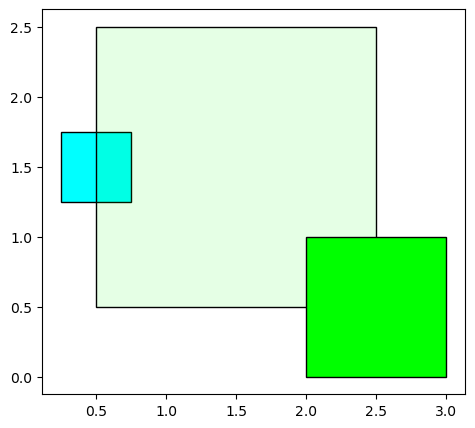

In [14]:
## CODE EXECUTION

ll = [[(0.25,0.9),(0.25,.9)]]
L = [[(0.85,0.25)],[(1.0,0.25)]]
cl = [[0,0],[0.25,0]]
cu = [[0,0.25],[0,0]]
b = (0.75, 0.25)
lll = [[(0.25,0.9),(0.25,.9), (0.25,.9)]]
lBl = [[(0.25,0.9),[[.25],[.25]], (0.25,.9)]]
LL = [[(0.85,0.25)],
     [0],
     [(0.85,0.25)]]
L_L = [[(0.43,0.25),(0.43,0.25)],
     [0,0],
     [(0.43,0.25),(0.43,0.25)]]

l = (0.6,0.8)

T = Terrain([
             [1,ll,cl,0],#3 total
             [ll,0,0,0],#3 total
             [ll,0,0,0],#6 total
             [ll,0,0,0],#6 total
             [ll,cl,0,0],#6 total
#             [ll,cl,0,0],#9 total
#             [ll,cl,0,0],#9 total
#             [ll,cl,0,0],#9 total
             [cu,L,L,1],
            ],
#            1.0,1.0,(0,0),(2,3)) #3 total
            1.0,1.0,(0,0),(5,3)) #6 total
#            1.0,1.0,(0,0),(8,3)) #9 total

T = Terrain([
             [1,ll,L,L,1],#3 total
             [ll,0,0,0,ll],#3 total
             [ll,0,0,0,ll],#6 total
             [cu,L,L,L,1],
            ],
            1.0,1.0,(0,0),(3,4)) #6 total
T = Terrain([
             [1 ,L,L,cl],#3 total
             [ll,0,cu,ll],#3 total
             [ll,cl,0,ll],#6 total
             [cu,L,L,1],
            ],
            1.0,1.0,(0,0),(3,3)) #6 total

# This is the terrain that gives the good gait
T = Terrain([
             #[1,[[0.25,0.25],[0.25,0.25]],[[0.25,0.25],[0.25,0.25]],1],
             [1,ll, lBl, ll,1],
            ],
            0.5,0.5,(0,0),(0,4))

T = Terrain([
             #[1,[[0.25,0.25],[0.25,0.25]],[[0.25,0.25],[0.25,0.25]],1],
             [1,ll, L,ll,1],
            ],
            0.5,0.5,(0,0),(0,4))

## Hard terrain sent to whatsapp
#T = Terrain([
#             #[1,[[0.25,0.25],[0.25,0.25]],[[0.25,0.25],[0.25,0.25]],1],
#             [1,ll, lBl, ll,0],
#             [0, 0,   0, L, 1]
#            ],
#            0.5,0.5,(0,0),(1,4))
#T = Terrain([
#             #[1,[[0.25,0.25],[0.25,0.25]],[[0.25,0.25],[0.25,0.25]],1],
#             [(1,1.2),L_L,L_L,(1,1.2)]
#            ],
#            0.5,0.5,(0,0),(0,3))
#T = Terrain([
#             #[1,[[0.25,0.25],[0.25,0.25]],[[0.25,0.25],[0.25,0.25]],1],
#             [(1,1.2),L,L,L,0],
#             [0,      0,0,L,(1,1.2)]
#            ],
#            0.5,0.5,(0,0),(1,4))
            
#T = Terrain([
#             #[1,[[0.25,0.25],[0.25,0.25]],[[0.25,0.25],[0.25,0.25]],1],
#             [1,l, l, l, l, l, 0],
#             [0, 0,   0, 0, L, L, 1]
#            ],
#            0.5,0.5,(0,0),(1,6))
#
#T = Terrain([
#             #[1,[[0.25,0.25],[0.25,0.25]],[[0.25,0.25],[0.25,0.25]],1],
#             [1,l,l,l,l,1]
#            ],
#            0.5,0.5,(0,0),(0,5))

ll = [[(0.10,0.75),(0.10,.75)]]
lBl = [[(0.10,0.75),[[.05],[.05]], (0.10,.75)]]
L = [[(0.6,0.05)],[(0.6,0.05)]]
uL = [[(0.6,0.05)], [0]]
lL = [[0], [(0.6,0.05)]]
#
V = [[0,b,0],[0.1,0.1,0.1]]
#T = Terrain([
#             #[1,[[0.25,0.25],[0.25,0.25]],[[0.25,0.25],[0.25,0.25]],1],
#             [(1,1.4),l,lBl,lL,0],
#             [0,    0, uL,L,(1,1.4)]
#            ],
#            0.5,0.5,(0,0),(1,4))
#
#T = Terrain([
#             #[1,[[0.25,0.25],[0.25,0.25]],[[0.25,0.25],[0.25,0.25]],1],
#             [(1.2,1.4),l,lBl,V,(1,1.4)],
#             [0,        0, 0, 0,      0],
#            ],
#            0.5,0.5,(0,0),(0,4))

T = Terrain([
             [1,ll,lBl,L,1],
            ],
            0.5,0.5,(0,0),(0,4))

T = Terrain([
             #[1,[[0.25,0.25],[0.25,0.25]],[[0.25,0.25],[0.25,0.25]],1],
             [(1.2,1.4),l,lBl,V,(1.2,1.4)],
             [0,        0, 0, 0,      0],
            ],
            0.5,0.5,(0,0),(0,4))

# Okay this one ACTUALLY solves
T = Terrain([
             [0.5,2,(0,0)],
             [0,0,1],
            ], 
            1.0,1.0,(0,0),(1,2))

T.plot()

T.store_terrain_to_file("not_lukas_terrain_dict.txt")
for stone in T.stepping_stones:
    print("c=", stone.center, " w=", stone.width, " h=", stone.height)

INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and rounding.
INFO:drake:Finished 100 rounding trials with Clarabel.
Graph build done, len(V)= 19  len(E)= 54
-------------------------------------------------------------
           Clarabel.rs v0.7.1  -  Clever Acronym              

                   (c) Paul Goulart                          
                University of Oxford, 2022                   
-------------------------------------------------------------

problem:
  variables     = 531
  constraints   = 1710
  nnz(P)        = 0
  nnz(A)        = 3868
  cones (total) = 218
    :        Zero = 1,  numel = 237
    : Nonnegative = 217,  numel = (1,1,1,1,...,1257)

settings:
  linear algebra: direct / qdldl, precision: 64 bit
  max iter = 200, time limit = Inf,  max step = 0.990
  tol_feas = 1.0e-8, tol_gap_abs = 1.0e-8, tol_gap_rel = 1.0e-8,
  static reg : on, ϵ1 = 1.0e-8, ϵ2 = 4.9e-32
  dynamic reg: on, ϵ = 1.0e-13, δ = 2.0

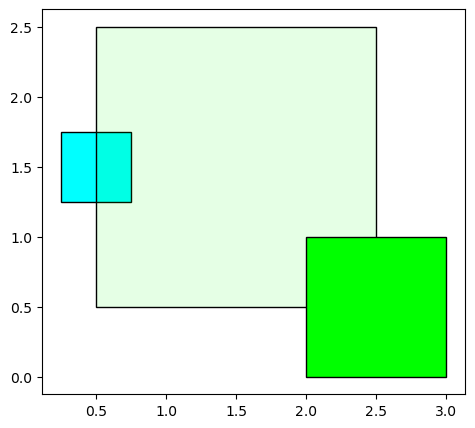

In [15]:
convex_relaxation = True
#solver = SnoptSolver()#MosekSolver()
#solver = MosekSolver()
solver = ClarabelSolver()

G, book_keeping = build_GCS_graph(T)
position_left, position_right, result = solve_gcs_problem(T, convex_relaxation, solver, G, book_keeping)

custom_animate_footstep_plan(T, step_span, sprawl_spanx, sprawl_spany, position_left, position_right, "footsteps :)")

#print(result_clarabel.GetSolution())

T.plot()

In [16]:
print(position_left)
print(position_right)

[[0.75       1.75      ]
 [0.75       1.75      ]
 [0.75       1.75      ]
 [0.75       1.75      ]
 [1.60092741 1.24436771]
 [1.60092741 1.24436771]
 [1.60092741 1.24436771]
 [1.60092741 1.24436771]
 [2.25       0.75      ]
 [2.25       0.75      ]]
[[0.75       1.25      ]
 [0.75       1.25      ]
 [1.35141673 1.37196627]
 [1.35141673 1.37196627]
 [1.35141673 1.37196627]
 [1.35141673 1.37196627]
 [2.18244852 0.71068362]
 [2.18244852 0.71068362]
 [2.18244852 0.71068362]
 [2.25       0.25      ]]


c= [0.5 1.5]  w= 0.5  h= 0.5
c= [1.5 1.5]  w= 2.0  h= 2.0
c= [2.5 0.5]  w= 1.0  h= 1.0


{'initial': {'x': 0.5, 'y': 1.5, 'length': 0.5, 'width': 0.5, 'height': 0.1}, 'stone_0_1': {'x': 1.5, 'y': 1.5, 'length': 2.0, 'width': 2.0, 'height': 0.1}, 'goal': {'x': 2.5, 'y': 0.5, 'length': 1.0, 'width': 1.0, 'height': 0.1}}
3


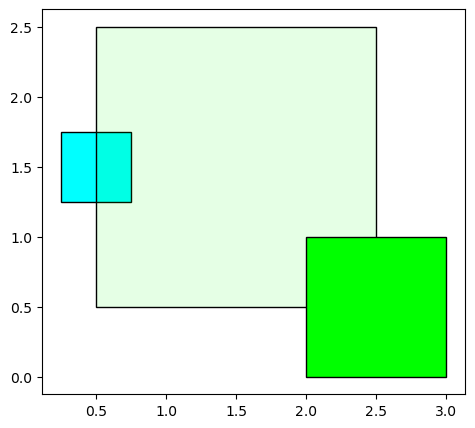

In [17]:
ll = [[(0.3,0.9),(0.3,.9)]]
L = [[(0.7,0.25)],[(0.7,0.25)]]
l = (0.8,1)
cl = [[0,0],[0.35,0]]
cu = [[0,0.35],[0,0]]
b = (0.75, 0.35)
lll = [[(0.25,0.9),(0.25,.9), (0.25,.9)]]
lBl = [[(0.25,0.9),[[.35],[.35]], (0.25,.9)]]
LL = [[(0.85,0.25)],
     [0],
     [(0.85,0.25)]]
L_L = [[(0.43,0.25),(0.43,0.25)],
     [0,0],
     [(0.43,0.25),(0.43,0.25)]]
V = [[0,b,0],[0.3,0.3,0.3]]
T = Terrain([
             #[1,[[0.25,0.25],[0.25,0.25]],[[0.25,0.25],[0.25,0.25]],1],
             [(1.2,1.4),ll, lBl, ll,(1.2,1.4)],
             [0, 0,   0, 0, 0]
            ],
            0.5,0.5,(0,0),(0,4))

T = Terrain([
             #[1,[[0.25,0.25],[0.25,0.25]],[[0.25,0.25],[0.25,0.25]],1],
             [(1.2,1.4),l,lBl,V,(1.2,1.4)],
             [0,        0, 0, 0,      0],
            ],
            0.5,0.5,(0,0),(0,4))

# Okay this one ACTUALLY solves
T = Terrain([
             [0.5,2,(0,0)],
             [0,0,1],
            ], 
            1.0,1.0,(0,0),(1,2))

T.plot()

T.store_terrain_to_file("test_terrain.txt")
for stone in T.stepping_stones:
    print("c=", stone.center, " w=", stone.width, " h=", stone.height)

custom_animate_footstep_plan(T, step_span, sprawl_spanx, sprawl_spany, position_left, position_right, "footsteps :)")

f = open("test_terrain.txt", "rb")
terr_dict = pickle.load(f)

print(terr_dict)
print(len(terr_dict))

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a45cd6cf-c8cd-4212-9b4f-261528e6e6af' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>